# Comparison of calcium activity in EPG's between wild type and GluCla-CRISPR lines

## Imports

In [109]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from showinfm import show_in_file_manager
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42


import sys
sys.path.append(os.path.join(os.getcwd(), "GluPuff_Pipeline.py"))
from GluPuff_Pipeline import process_trial, plot_trial
import imganlys.ImagingPreProc as iPP

# Using qt since not plotting inline :(
%matplotlib inline

## Plotting

### Load in trials, If a trial was not preprocessed, process it. 

In [22]:
# Using xarray
# Comparing 2 trial conditions in 3 different trials each
shape = (2, 3)

proc_trial_nms = xr.DataArray(np.empty(shape=shape, dtype=object),
                    dims=('condition', 'trial'),
                    coords={'condition': ['A', 'B'],
                            'trial': range(3)})

# Condition A trials
proc_trial_nms.loc[dict(condition='A', trial=0)] = iPP.cleanPath(os.path.join(r"Z:\2PImaging\Jorin\HD7xCRISPR\B5_3.1.23\tiffs", "B5_p1_1uA_25ms.tif"))
proc_trial_nms.loc[dict(condition='A', trial=1)] = iPP.cleanPath(os.path.join(r"Z:\2PImaging\Jorin\HD7xCRISPR\B5_3.1.23\tiffs", "B5_p2_0.5uA_25ms.tif"))
proc_trial_nms.loc[dict(condition='A', trial=2)] = iPP.cleanPath(os.path.join(r"Z:\2PImaging\Jorin\HD7xCRISPR\B5_3.1.23\tiffs", "B5_p3_2uA_25ms.tif"))

# Condition B trials
proc_trial_nms.loc[dict(condition='B', trial=0)] = iPP.cleanPath(os.path.join(r"Z:\2PImaging\Kerstin\20230223_HD7-WTB\tiffs", "20230223_HD7-WTB_brain1_r1.tif"))
proc_trial_nms.loc[dict(condition='B', trial=1)] = iPP.cleanPath(os.path.join(r"Z:\2PImaging\Kerstin\20230223_HD7-WTB\tiffs", "20230223_HD7-WTB_brain1_r2.tif"))
proc_trial_nms.loc[dict(condition='B', trial=2)] = iPP.cleanPath(os.path.join(r"Z:\2PImaging\Kerstin\20230223_HD7-WTB\tiffs", "20230223_HD7-WTB_brain1_r3.tif"))

# print(proc_trials)

Process any unprocessed trials

In [23]:
PROC_DAT_FOLDER = os.path.join(os.getcwd(), "..", "results", "pickle")

expt_dat = {}
for trial_nm in proc_trial_nms.values.flatten():
    if not os.path.isfile(iPP.getPicklePath(trial_nm, PROC_DAT_FOLDER)):
        # If there is no preprocessed trial, process it
        expt_dat[trial_nm] = process_trial(trial_nm, PROC_DAT_FOLDER)
iPP.saveTrials(expt_dat, PROC_DAT_FOLDER)

Load in all trials

In [24]:
proc_trials = xr.DataArray(np.empty(shape=shape, dtype=object),
                    dims=('condition', 'trial'),
                    coords={'condition': ['A', 'B'],
                            'trial': range(3)})

for cond in proc_trial_nms:
    cond_num = str(cond.coords['condition'].values)
    for trial in cond:
        trial_num = int(trial.coords['trial'].values)
        proc_data_fn = iPP.getPicklePath(str(trial.values), PROC_DAT_FOLDER)
        proc_trials.loc[dict(condition=cond_num, trial=trial_num)] = iPP.loadProcData(proc_data_fn)

### Plot trials

In [123]:
# Folder to save plot in
outfolder = os.path.join(os.getcwd(), "..", "results", "plots", "comparison_plots")

timestamp = datetime.strftime(datetime.now(), "%d-%m-%Y_%H-%M-%S")
outname = f"comparison_figure_{timestamp}.svg"
outpath = os.path.join(outfolder, outname)

In [63]:
def create_cmap(vmin=-1, vmax=1):
    cmap = cm.get_cmap('PiYG')

    lim = max(abs(vmin), abs(vmax))

    newcolors = cmap(np.linspace(-1*lim, lim, 256))
    return ListedColormap(newcolors, name='PiYG-centered')

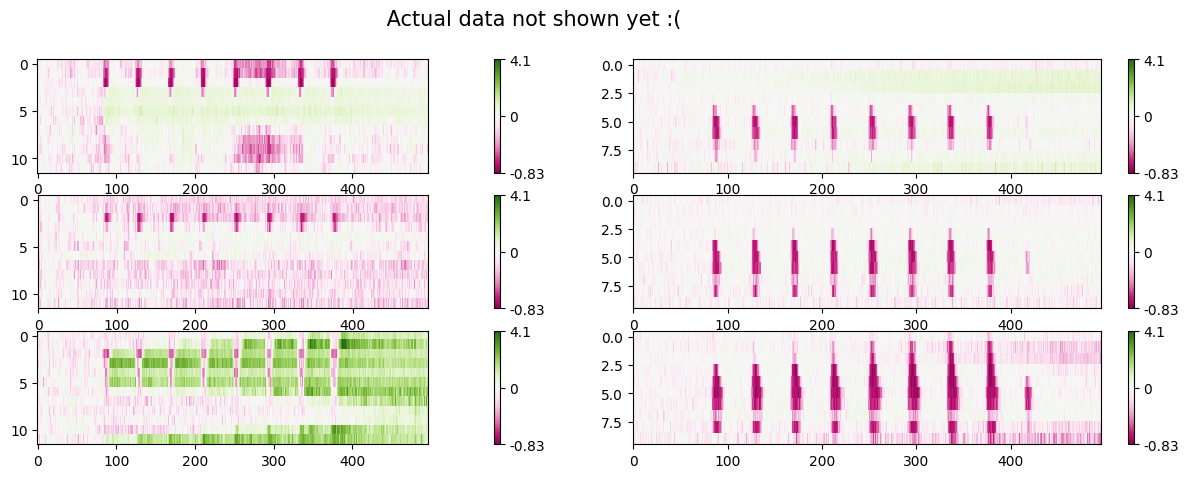

In [131]:
# TODO plot all trials togother in a comparison

fig_width = 15
fig_height = 5
fig = plt.figure(figsize=(fig_width, fig_height))

nrows, ncols = 3, 2

outer_grid = fig.add_gridspec(nrows, ncols)


total_lims = {'raw_flor': {'vmin': None, 'vmax': None},
        'delta_flor': {'vmin': None, 'vmax': None}}

# Calculate vmin and vmax
for cond, col in zip(['A', 'B'], [0, 2]):
    for row in range(3):
        trial = proc_trials.loc[dict(condition=cond, trial=row)]
        raw_flor = trial.to_dict()['data']['raw_flor']
        delta_flor = trial.to_dict()['data']['delta_flor']

        trial_lims = {'raw_flor': {'vmin': None, 'vmax': None},
                      'delta_flor': {'vmin': None, 'vmax': None}}
        trial_lims['raw_flor']['vmin'], trial_lims['raw_flor']['vmax']  = [np.amin(raw_flor), np.amax(raw_flor)]
        trial_lims['delta_flor']['vmin'], trial_lims['delta_flor']['vmax']  = [np.amin(delta_flor), np.amax(delta_flor)]

        for flor, lims in trial_lims.items():
            if (total_lims[flor]['vmin'] is None) or (trial_lims[flor]['vmin'] < total_lims[flor]['vmin']):
                total_lims[flor]['vmin'] = trial_lims[flor]['vmin']
            if (total_lims[flor]['vmax'] is None) or (trial_lims[flor]['vmax'] > total_lims[flor]['vmax']):
                total_lims[flor]['vmax'] = trial_lims[flor]['vmax']

vmin = total_lims['delta_flor']['vmin']
vmax = total_lims['delta_flor']['vmax']

divnorm=TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

# Create axes
for row in range(nrows):
    for cond, col in zip(['A', 'B'], range(ncols)):
        trial = proc_trials.loc[dict(condition=cond, trial=row)]
        # Get delta florescence
        delta_flor = trial.to_dict()['data']['delta_flor']

        # Create inner gridspec
        inner_grid = outer_grid[row, col].subgridspec(1, 2,
                                                      width_ratios=[1, 0.01],
                                                      wspace=0)
        axs = inner_grid.subplots()

        # Plot delta florescence
        flor_plot = axs[0].imshow(
            delta_flor.T, aspect = 12,
            norm=divnorm,
            interpolation='nearest',
            cmap='PiYG'
            )
        
        # Plot colorbar
        cbar = fig.colorbar(flor_plot, cax=axs[1])
        cbar.set_ticks([vmin, 0, vmax])
        cbar.ax.set_yticklabels([f"{lim:.2g}" for lim in [vmin, 0, vmax]])

fig.suptitle(' Actual data not shown yet :( ', fontsize=15)

fig.savefig(outpath, dpi=600)


In [75]:

cmap = cm.get_cmap('PiYG')
newcolors = cmap(np.linspace(0, 2, 256))
print(cmap(np.linspace(0, 1, 128)))
print(cmap(np.linspace(0, 2, 128)))

[[0.55686275 0.00392157 0.32156863 1.        ]
 [0.57377932 0.01191849 0.33479431 1.        ]
 [0.59069589 0.01991542 0.34801999 1.        ]
 [0.60761246 0.02791234 0.36124567 1.        ]
 [0.62452903 0.03590927 0.37447136 1.        ]
 [0.6414456  0.04390619 0.38769704 1.        ]
 [0.65836217 0.05190311 0.40092272 1.        ]
 [0.67527874 0.05990004 0.4141484  1.        ]
 [0.69219531 0.06789696 0.42737409 1.        ]
 [0.70911188 0.07589389 0.44059977 1.        ]
 [0.72602845 0.08389081 0.45382545 1.        ]
 [0.74294502 0.09188774 0.46705113 1.        ]
 [0.75986159 0.09988466 0.48027682 1.        ]
 [0.77447136 0.11295656 0.49396386 1.        ]
 [0.78216071 0.14125336 0.50903499 1.        ]
 [0.78985006 0.16955017 0.52410611 1.        ]
 [0.79753941 0.19784698 0.53917724 1.        ]
 [0.80522876 0.22614379 0.55424837 1.        ]
 [0.81291811 0.2544406  0.56931949 1.        ]
 [0.82060746 0.28273741 0.58439062 1.        ]
 [0.82829681 0.31103422 0.59946175 1.        ]
 [0.83598616 

In [38]:
print(trial.to_dict()['data']['raw_flor'])

[[110044.  98494. 200806. ...  52602. 103439.  36795.]
 [118945. 100476. 177328. ...  54019. 117786.  36334.]
 [102901.  78250. 200776. ...  46098.  92982.  29343.]
 ...
 [123737. 105164. 207708. ...  48842. 106366.  35776.]
 [110293.  88314. 176843. ...  49519. 111900.  37429.]
 [ 89575.  71669. 189569. ...  35090. 106974.  26887.]]


In [65]:
fig.show()

Open folder with plots

In [ ]:
if os.name == 'nt':
    outfolder = outfolder.replace('/', '\\')
show_in_file_manager(outfolder)